Extract Fetures

In [ ]:

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
    return mfccsscaled

Load .CSV File

In [ ]:

x=pd.read_csv('/content/last.csv',index_col=[0])
x.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,lable
251,-319.57605,138.042430,7.241458,16.703661,-18.078920,17.455560,-7.225351,19.654009,-3.404079,18.466080,2.607739,5.391242,-8.173417,3.410312,-3.369479,6.468385,-12.374643,-2.331567,-4.841918,0.846552,1.145119,-2.468728,1.304922,1.888435,1.393825,0.784727,4.352632,4.758812,5.493302,4.405087,6.430973,5.961862,5.768207,3.051609,4.324793,3.647876,5.012327,1.838750,3.473247,3.258515,Hooded_Crow
135,-382.45554,119.422485,-17.037863,-10.599563,-21.015398,15.077116,-9.743347,-0.633109,-11.597214,8.204327,-7.635789,5.419267,-13.687733,2.768140,-2.046531,3.118486,-2.620243,2.010378,-5.308038,6.582541,0.355052,0.461957,-1.593112,-0.792170,2.740923,5.119875,-0.665905,0.099937,0.576190,1.859915,4.383880,-0.249756,-0.457933,0.980270,1.452133,1.244972,0.117959,-2.954189,0.879462,0.808179,Scops_Owl
177,-248.93962,103.913000,27.924562,41.944782,32.583990,24.709190,20.122108,13.554005,-0.721800,10.540181,6.226833,7.646826,-8.161373,8.638908,-6.564305,6.673932,-7.170571,5.343617,-10.685241,7.963097,-3.446601,5.495817,-3.979272,7.208024,-1.627233,6.457053,-1.384698,3.754825,-3.102351,5.693191,-1.783811,1.746695,-2.402383,3.281609,-2.192057,3.388964,-1.417221,1.634310,-0.974850,3.281206,Scops_Owl
299,-424.82720,61.643612,3.199503,23.865835,21.215057,15.774405,-0.552353,8.178884,1.840502,5.751625,0.750492,-0.263027,-1.636798,2.093975,-1.121334,-1.399026,-3.715501,-1.224519,-0.995751,1.037435,0.787253,0.321896,-1.613758,-0.495699,-1.144104,-0.008413,-0.384449,-1.338475,-2.344108,-1.174183,-0.169494,0.098948,-0.398889,-1.585827,-0.838890,0.014697,-0.509469,0.202141,-0.087353,0.179487,Hooded_Crow
16,-310.07233,122.203156,-31.536915,-40.288980,-7.742925,-24.657337,-11.518000,-21.019276,-20.061464,-5.540217,-8.049480,-4.986896,-13.003305,-0.149003,-7.026916,4.274756,-4.552034,2.402934,-3.997850,5.872474,1.099328,5.095015,0.215212,3.703888,2.472053,5.537352,2.269928,1.947945,2.773561,3.461640,4.150666,0.979547,1.324451,1.486756,3.294991,0.324361,1.317390,-0.099054,1.840093,0.986186,Scops_Owl


Shuffle CSV data

In [ ]:
from sklearn.utils import shuffle
shuff = shuffle(x)
shuff.to_csv('shuffled.csv')

Extract Labels

In [ ]:
y=shuff['lable']
y.head(5)

6        Scops_Owl
222    Hooded_Crow
208    Hooded_Crow
354    Hooded_Crow
80       Scops_Owl
Name: lable, dtype: object

Extract Feature Values

In [ ]:
del shuff['lable']
x=shuff.values
x[0]

array([-6.76136050e+02,  1.25546100e+01, -4.88609500e+01, -2.06065880e+01,
        1.15480480e+01,  1.00753765e+01,  9.73102700e+00, -3.47548270e+00,
       -1.87215560e+01, -1.93948610e+00,  1.64204600e+01,  1.00275980e+01,
       -1.42745660e+00, -8.79544300e+00, -8.25134850e+00,  1.12108790e+00,
        3.82775600e+00,  1.58553100e+00,  2.38476540e+00, -1.58966460e+00,
       -3.20774840e+00,  2.77966300e+00,  1.40075680e+00, -2.41341900e+00,
       -1.59251240e-01, -2.52302380e+00, -7.02396500e-01,  1.03855910e+01,
        4.88150900e+00, -1.19232260e+01, -9.12263300e+00,  3.79390530e+00,
        5.99091600e+00,  2.83890370e+00, -3.87999300e-01, -2.95661700e+00,
       -1.40720380e+00,  1.97333700e+00,  3.88717460e+00,  1.22029160e+00])

Encode the labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(y)

LabelEncoder()

Current no. of Classes in labels data

In [ ]:
le.classes_

array(['Hooded_Crow', 'Scops_Owl'], dtype=object)

Create Feed Forward Model

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

Split train and test data

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Import libraries necessary for Creating model

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

No. of output classes

In [ ]:
num_class= le.classes_.shape[0]
num_class

2

Model layer structure

In [ ]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_class))
model.add(Activation('softmax'))

Compile model

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

Train model until 400 epochs 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 400
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='/content/saved/checkpoint.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Evaluate Accuracy of the model

In [ ]:
test_accuracy=model.evaluate(x_test,y_test,verbose=0)
print(test_accuracy[1])

0.925000011920929


Plot training and validation ( loss - accuracy ) parameters  

<Figure size 432x288 with 0 Axes>

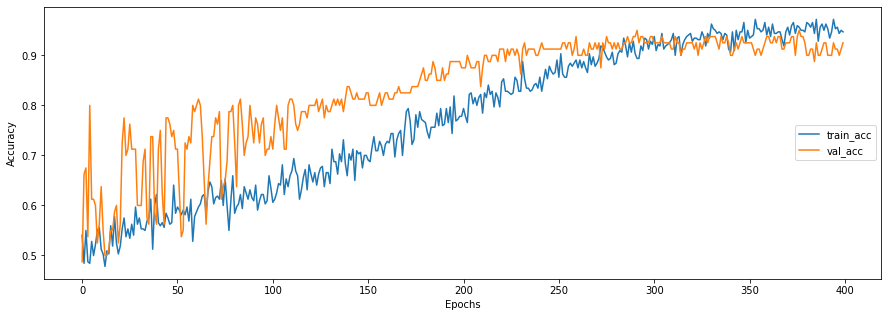

<Figure size 432x288 with 0 Axes>

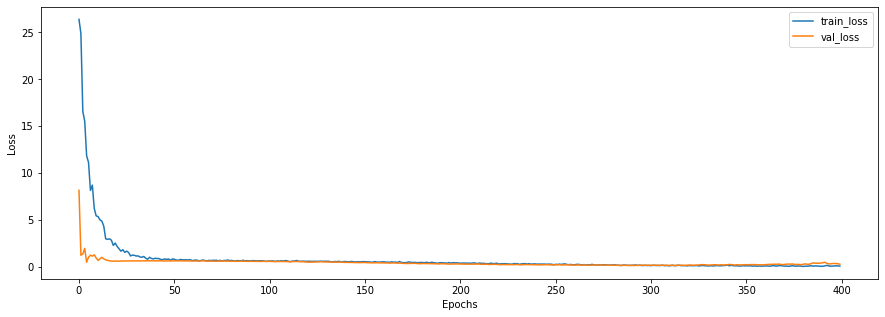

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc    = history.history['val_accuracy']
val_loss   = history.history['val_loss']
epochs     = range(len(train_acc))

plt.figure(figsize=(15,5))
# Accuracy
plt.plot(epochs,train_acc)
plt.plot(epochs,val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_acc','val_acc'], loc='center right')
plt.figure()
#plt.savefig('Accuracy_till_4_class_500.png')

plt.figure(figsize=(15,5))
# Loss
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss','val_loss'], loc='upper right')
plt.figure()
#plt.savefig('Loss_till_4_class_500.png')


Load prediction audio file

In [ ]:

filename="/content/Hooded_Crow (203).mp3"
ipd.Audio(filename)


Predict audio

In [ ]:

mfccs_scaled_features = extract_features(filename)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)

pr=model.predict(mfccs_scaled_features)
agmax = np.argmax(pr)
per = pr[0][agmax]

predict_label = le.inverse_transform([agmax])[0]
print(" \n\n ==========>",predict_label," ",round(per*100,2),"%","<========== \n\n")





/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


 

 ==========> Hooded_Crow   100.0 % <========== 


